# Vanilla ABC-SMC 
Set up requrirements and experimental data

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 22 18:22:52 2020

@author: marcofking
"""


import pyabc as pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
#import scipy as sp
import seaborn as sns
from scipy.integrate import odeint
import math
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test3.db"))





# Plot the data

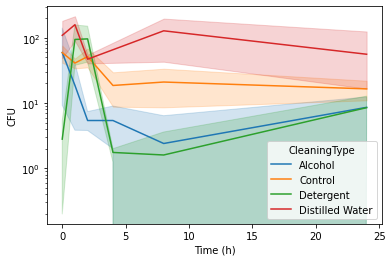

In [2]:
#Could use PlotNine which is like ggplot2 
#Import LabData/cleaningExptBeth.csv
import pandas as pd
import seaborn as sns
LabData = pd.read_csv('../../LabData/cleaningExptBeth.csv')

#using seaborn make a line plot of Count vs TimeAfterCleaning and colour by CleaningType, on log scale 
#replace NANs in Count with 0
LabData['Count'] = LabData['Count'].fillna(0)
g=sns.lineplot(x='TimeAfterCleaning', y='Count', hue='CleaningType', data=LabData)
g.set(yscale="log")
_ = g.set(xlabel="Time (h)", ylabel="CFU")

# find the mean and standard deviation
M = LabData.groupby(['CleaningType','TimeAfterCleaning']).mean()
S = LabData.groupby(['CleaningType','TimeAfterCleaning']).std()




# Define the ODE to solve 

1) If we wanted to consider proliferation on hands instead of surface accrual then we could use:
$$ y'=y(1-\dfrac{y}{C})l-d\exp(-g t)y$$

$C$ is carrying capacity. $d$ is maximum effecicacy. $g$ is decay from the disinfectant. $r$ recontamination from contacts (this is linear). $l$ is the proliferation rate on the hands.

3) Proliferation and increase from airborne deposition can be combined:
$$ y'=(yl+r)(1-\dfrac{y}{C})-d\exp(-g t)y$$

But since we don't see any saturation then we could ignore carrying capacity. 
$$ y'=(yl+r)(1-y)-d\exp(-g t)y$$

However with the data we have it is unlikely that we can learn about $l$ and $r$ together.

Ideally we should learn about proliferation from all experimental data

Notes: 12th April
- But we never reach a saturation so maybe we shouldn't consider $C$ at all.


Notes: 14th April
- Using a distance that divides by SD means that it doesn't predict the first time-point after 0 well.
- $ y'=yl-d\exp(-g t)y$ considers only proliferation on the surface and no recontamination from external sources.
- Why don't we include a movable initial condition?

In [3]:
#Here we define the ODE model (1)- we use inferred parameter ranges from lienar regression r=0.18, d=1146, g=1.18, C=unknown
def ode_model(contamination,t,C,r,d,g):
    Contamination = contamination;
    return(Contamination*r*(1-Contamination/C)-d*math.exp(-g*t)*Contamination)

#Here we create the input parameters and extract only specific time-points
def deterministic_run(parameters):#precision,initial_contamination,r,C,d,g):
    precision=5000
    tmax = 24
    time_space = np.linspace(0,tmax,precision+1)#precision+1?
    sim=odeint(ode_model,initial_contamination,time_space,args=(parameters["C"],parameters["r"],parameters["d"],parameters["g"]))
    num_at_2=sim[int(precision*2/tmax)]
    num_at_4=sim[int(precision*4/tmax)]
    num_at_8=sim[int(precision*8/tmax)]
    num_at_12=sim[int(precision*12/tmax)]
    num_at_24=sim[int(precision*24/tmax)]
    return{"Contamination":[num_at_2,num_at_4,num_at_8,num_at_12,num_at_24]} #+ 0.2*np.random.randn(5)
    #return{"Contamination":[num_at_2,num_at_4,num_at_6]}

# Define the parameter priors

We choose some examples to see how well it works.

In [4]:
parameter_prior = Distribution(C=RV("uniform", 6.0, 15.0),
                               r=RV("uniform", 0.1, 4.0),
                               d=RV("uniform", 1.0, 4.0),
                               g=RV("uniform", 0.01, 1.0))

parameter_prior.get_parameter_names()


['C', 'd', 'g', 'r']

# Define the distance fuction
This currently is a absolute distances between the two points divided by the standard deviation at each point. Could use Manhattan distance.

In [5]:
def distance(simulation, data):
    return np.absolute((data["Contamination"] - simulation["Contamination"])).sum()

# Set up the ABC SMC 


In [6]:
#sigma=0.02
#acceptor = pyabc.StochasticAcceptor()
#kernel = pyabc.IndependentNormalKernel(var=sigma**2)
#eps = pyabc.Temperature()

#abc = pyabc.ABCSMC(deterministic_run, parameter_prior, kernel, eps=eps, acceptor=acceptor,population_size=1000)
#abc.new(db_path,{"Contamination": measurement_data}) #This distance model assumes the name of the predicited and confirmed are the same
#history_acceptor = abc.run(max_nr_populations=5,minimum_epsilon=50000)

In [7]:
# We plug all the ABC options together
#Using adaptive population size and local transition
#eps = pyabc.AdaptiveEpsilon(0.001, decay=0.1, limit=0.1)
#acceptor = pyabc.StochasticAcceptor()
#kernel = pyabc.IndependentNormalKernel(var=sigma**2)

from pyabc.populationstrategy import AdaptivePopulationSize


abc = ABCSMC(
    models=deterministic_run,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=AdaptivePopulationSize(1000, 0.15),
    # population_size=1000,
    transitions=LocalTransition(k_fraction=0.3),
    # eps=MedianEpsilon(500, median_multiplier=0.7),
)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


# Setting the observed data

Here we define the initial conditions as well as the observed lab data. 
All ten participants washed their hands for 1 minute with soft soap and then used a paper towel to dry their hands. Participants were then asked to rub their fingertips and thumb for 1 minute.
 time_0 refers to immediatelly after hand hygiene so in reality this might be 5 or 10 minutes after.

In [8]:
initial_contamination=59
measurement_data = np.array([19,5,5,2,9])
s=np.array([26,2.3,4.67,4.33,4.27])
precision=5000
measurement_times = np.array([1,2,4,8,24])#np.arange(len(measurement_data))  

#This sets up the database and includes the measurement data and standard deviation
history = abc.new(db_path, {"Contamination": measurement_data,"sd":s})

ABC.History INFO: Start <ABCSMC id=16, start_time=2022-04-14 15:44:51>


# Running the ABC

In [9]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.70111022e+02.
ABC INFO: Accepted: 1000 / 1966 = 5.0865e-01, ESS: 1.0000e+03.
ABC.Adaptation INFO: Change nr particles 1000 -> 544
ABC INFO: t: 1, eps: 1.36734167e+02.
ABC INFO: Accepted: 544 / 1191 = 4.5676e-01, ESS: 5.0417e+02.
ABC.Adaptation INFO: Change nr particles 544 -> 562
ABC INFO: t: 2, eps: 1.21191583e+02.
ABC INFO: Accepted: 562 / 1288 = 4.3634e-01, ESS: 4.9971e+02.
ABC.Adaptation INFO: Change nr particles 562 -> 609
ABC INFO: t: 3, eps: 1.16285692e+02.
ABC INFO: Accepted: 609 / 1427 = 4.2677e-01, ESS: 5.3939e+02.
ABC.Adaptation INFO: Change nr particles 609 -> 566
ABC INFO: t: 4, eps: 1.13431656e+02.
ABC INFO: Accepted: 566 / 1490 = 3.7987e-01, ESS: 3.3518e+02.
ABC.Adaptation INFO: Change nr particles 566 -> 596
ABC INFO: t: 5, eps: 1.11911671e+02.
ABC INFO: Accepted: 596 / 1505 = 3.9601e-01, ESS: 1.6778e+02.
ABC.Adaptation INFO: Change nr particles 596 -> 588
ABC INFO: t: 6, eps: 1.10877762e+02.
ABC INFO: Accepted

# Visualise the probability density functions


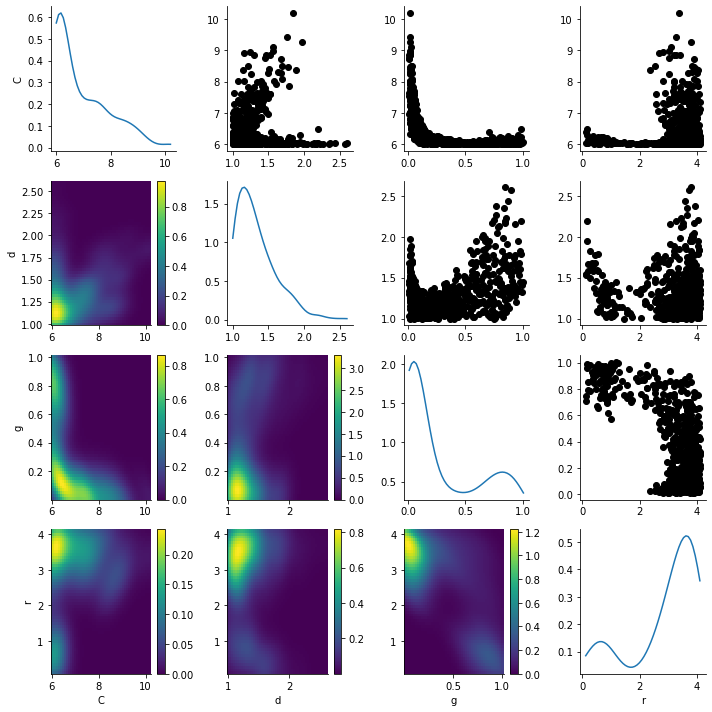

In [10]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w);

## Visualise how the parameters converge over populations

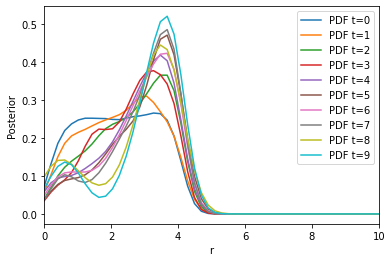

In [11]:
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=10,
        x="r",
        # xname=r"$\lambda$",
        ax=ax,
        label=f"PDF t={t}",
    )
#Add a vertical line at lambda=0.49 +- 0.32 to 0.72 
#This is the experimental value predicted in King et al. 2020 with Kalanne
ax.axvline(15, color="k", linestyle="dashed")
ax.legend();

# Summary statistics

First some summary statistics and save to file

In [12]:
df.to_csv("Outputs/abc_results.csv", encoding='utf-8', index=False)
df.describe()

name,C,d,g,r
count,718.000000,718.000000,718.000000,718.000000
mean,6.424132,1.279350,0.335078,3.215564
std,0.626989,0.259648,0.296222,0.948028
min,6.000173,1.000049,0.010251,0.114866
25%,6.046141,1.094544,0.069419,3.104263
50%,6.137473,1.211999,0.240627,3.534173
75%,6.524980,1.368257,0.569151,3.815719
max,10.192369,2.603648,1.007337,4.095876


# Plot some trajectories


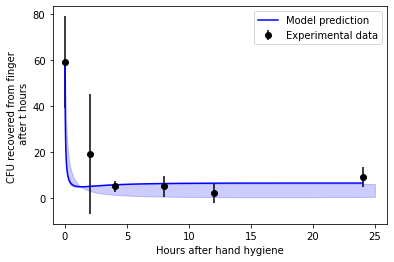

In [13]:
import pandas as pd
import operator


#plot some curves from the ODE model
precision=5000
tmax = 24
time_space = np.linspace(0,tmax,precision+1)#precision+1?

P=odeint(ode_model,initial_contamination,time_space,args=(df["C"].mean(),df["r"].mean(),df["d"].mean(),df["g"].mean()))
Pmin=odeint(ode_model,initial_contamination,time_space,args=(df["C"].quantile(0.05),df["r"].quantile(0.05),df["d"].quantile(0.05),df["g"].quantile(0.05)))
Pmax=odeint(ode_model,initial_contamination,time_space,args=(df["C"].quantile(0.05),df["r"].quantile(0.95),df["d"].quantile(0.95),df["g"].quantile(0.95)))


#Define new sd just for plotting to avoid SD value at 0
s=np.array([20,26,2.3,4.67,4.33,4.27])
measurement_data = np.array([59,19,5,5,2,9])

#Plot errobars of experimental data
x = np.array([0,2,4,8,12,24])
plt.errorbar(x,measurement_data,yerr=s,fmt='o', color='black',label='Experimental data')

#Plot the model prediction
plt.plot(time_space,P,label="Model prediction",color='blue')

#Plot confidence intervals around the model prediction

precision=5000
tmax = 25
time_space = np.linspace(0,tmax,precision+1)

plt.fill_between(time_space,np.concatenate(Pmin),np.concatenate(Pmax),alpha=0.2,color='blue')
#plt.plot(time_space,Pmin,label="Model prediction",color='red')
#plt.plot(time_space,Pmax,label="Model prediction",color='red')

#plt.fill_between(x, np.array(map(operator.sub, P["Contamination"], Pmin["Contamination"])), np.array(map(operator.add, P["Contamination"], Pmax["Contamination"])), color='b', alpha=.1)
plt.xlim(-1,26)
plt.ylabel("CFU recovered from finger \n after t hours")
#plt.yscale("log")
plt.xlabel("Hours after hand hygiene")
plt.legend(loc="upper right")
#make y axis logarithmic


#save the plot
#plt.savefig("../Images/abc_prediction.png", dpi=600)

plt.show()

In [14]:
# import parameter_sample_Alcohol_1K.csv 
aa=pd.read_csv("/Users/marcofking/Documents/GitHub/Cleaning/Code/ABCCODE/Outputs/parameter_sample_Alcohol_1K.csv")
#find the best parameters
aa.describe()

,r,C,d,g
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.313394,9.211914,1.872329,0.261362
std,0.281520,0.854669,0.087878,0.078367
min,0.734779,7.600934,1.611054,0.103618
25%,1.101537,8.548979,1.816454,0.198580
50%,1.281566,9.090434,1.887631,0.251047
75%,1.503314,9.780285,1.944810,0.320451
max,2.231144,11.816450,1.999993,0.498835


In [15]:
# Read in allCleanDataStephanie